In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

from scipy import stats

import xarray as xr
import geopandas as gpd
import xesmf as xe
import rioxarray as rio
import geoviews as gv

import geoviews.feature as gf

gv.extension("matplotlib")
gv.output( size = 600 )

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
# Códigos nacionales y subnacionales
ix  = "alpha-3"
ix1 = "iso_3166_2" 

wb_path = "../../Bases_de_datos/CCKP_NetCDF/"
map_path = "../../Bases_de_datos/Mapas/WB_countries_Admin0_10m"
borders_path = ( "../../Bases_de_datos/Mapas/"
    + "Natural_Earth/ne_50m_admin_0_countries" )
wb_files = os.listdir(wb_path)
for i, f in enumerate(wb_files):
    if f[0] in ["~", "."]: wb_files.remove(f)
for i, f in enumerate(wb_files): print(f"{i}: {f}")

borders = gpd.read_file(borders_path).rename(
    columns = {"ISO_A3_EH":ix} ).set_index(ix)
countries = gv.Path( borders[["geometry"]]
    ).opts( linewidth = 0.5, color = "k" )

#gdf = gpd.read_file(map_path)
#gdf["Area"] = gdf.to_crs(8857).area
#world = gdf.dissolve()
#world.plot()
#gdf.head()#.plot()

borders = borders[ borders["ISO_N3_EH"] != "-99" ]
borders["Area"] = borders.to_crs(8857).area
borders

0: climatology-pr-annual-mean_cmip6-x0.25_ensemble-all-historical_climatology_median_1995-2014.nc
1: climatology-popcount-annual-mean_pop-x0.25_gpw-v4-rev11-ssp245_climatology_mean_2040-2059.nc
2: climatology-spei12-annual-mean_cmip6-x0.25_ensemble-all-historical_climatology_median_1995-2014.nc
3: climatology-rx1day-annual-mean_cmip6-x0.25_ensemble-all-ssp245_climatology_median_2040-2059.nc
4: climatology-popcount-annual-mean_pop-x0.25_gpw-v4-rev11-historical_climatology_mean_1995-2014.nc
5: climatology-hd40-annual-mean_cmip6-x0.25_ensemble-all-historical_climatology_median_1995-2014.nc
6: climatology-pr-annual-mean_cmip6-x0.25_ensemble-all-ssp245_climatology_median_2040-2059.nc
7: climatology-hd40-annual-mean_cmip6-x0.25_ensemble-all-ssp245_climatology_median_2040-2059.nc
8: climatology-spei12-annual-mean_cmip6-x0.25_ensemble-all-ssp245_climatology_median_2040-2059.nc
9: climatology-rx1day-annual-mean_cmip6-x0.25_ensemble-all-historical_climatology_median_1995-2014.nc


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,Area
alpha-3,,,,,,,,,,,,,,,,,,,,,
ZWE,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,1,Zimbabwe,...,None,None,None,None,None,None,None,None,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344...",3.889936e+11
ZMB,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,1,Zambia,...,None,None,None,None,None,None,None,None,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643...",7.527751e+11
YEM,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,1,Yemen,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...",4.525663e+11
VNM,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,1,Vietnam,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...",3.278475e+11
VEN,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,1,Venezuela,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...",9.104385e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALB,Admin-0 country,1,6,Albania,ALB,0,2,Sovereign country,1,Albania,...,None,None,None,None,None,None,None,None,"POLYGON ((19.34238 41.86909, 19.34551 41.91885...",2.837307e+10
AFG,Admin-0 country,1,3,Afghanistan,AFG,0,2,Sovereign country,1,Afghanistan,...,None,None,None,None,None,None,None,None,"POLYGON ((66.52227 37.34849, 66.82773 37.37129...",6.418439e+11
ATA,Admin-0 country,3,4,Antarctica,ATA,0,2,Indeterminate,1,Antarctica,...,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-45.71777 -60.52090, -45.49971...",1.235647e+13


In [3]:
# Datos

# Carpetas
path_catalog = "../../Bases_de_datos/Data_catalog.csv"
data_d = "../results/"
iso = "../../Bases_de_datos/Country_ISO_code.csv"

# Relación de códigos Banco Mundial y Natural Earth (ISO 3166-2)
code_path = "../../Bases_de_datos/Subnational_Code_WB_ISO.csv"

# Catálogo de datos
df_c = pd.read_csv(path_catalog)


df_iso = pd.read_csv(iso).set_index(ix)

df_c.head()

,Dataset,ID,Origin,Countries,Granularity,Timestep,Annex,Website,Filename,Path
0,Exposure to sea level rise,pone.0118571.s004,Neumann et al.,All,National,Periods,NaN,https://doi.org/10.1371/journal.pone.0118571,pone.0118571.s004.csv,Bases_de_datos/Sea_level_rise/
1,Air Emissions Accounts,DF_AEA,OECD,All,National,"OECD: Quarterly, Non-OECD: Yearly",NaN,https://data-explorer.oecd.org,"OECD.SDD.NAD.SEEA,DSD_AEA@DF_AEA,1.0+all.csv",Bases_de_datos/OECD_Air_and_Climate/
2,Air emissions - Air pollutants Inventories,DF_AIR_EMISSIONS,OECD,All,National,Yearly,Air Emissions Correspondance Table.xlsx,https://data-explorer.oecd.org,"OECD.ENV.EPI,DSD_AIR_EMISSIONS@DF_AIR_EMISSION...",Bases_de_datos/OECD_Air_and_Climate/
3,Air emissions - Greenhouse gas emissions Inven...,DF_AIR_GHG,OECD,All,National,Yearly,NaN,https://data-explorer.oecd.org,"OECD.ENV.EPI,DSD_AIR_GHG@DF_AIR_GHG,1.0+all.csv",Bases_de_datos/OECD_Air_and_Climate/
4,Air transport CO2 emissions (experimental),DF_AIR_TRANSPORT,OECD,All,National,Monthly,NaN,https://data-explorer.oecd.org,"OECD.SDD.NAD.SEEA,DSD_AIR_TRANSPORT@DF_AIR_TRA...",Bases_de_datos/OECD_Air_and_Climate/


In [4]:
p = "climatology-popcount-annual-mean"

i = 4
pop_h = xr.open_dataset(wb_path + wb_files[i])
pop_h = pop_h.rio.write_crs(borders.crs)
i = 1
pop_f = xr.open_dataset(wb_path + wb_files[i])
pop_f = pop_f.rio.write_crs(borders.crs)

gdf_b = borders[borders["Area"] >= 1e9]
pop_h["country"] = pop_h[p].copy()

for i in gdf_b.index:
    ds_c = xr.full_like( pop_h[[p]],
        int(gdf_b.loc[gdf_b.index == i, "ISO_N3_EH"].iloc[0]) )
    pop_w = ds_c.rio.clip( gdf_b[gdf_b.index == i].geometry,
        drop = False, invert = False,all_touched = False )
    pop_h["country"] = pop_h["country"].where( pop_w[p].isnull(), pop_w[p] )

for l in range(2):
    iso = pop_h["country"].values
    iso_c  = iso.copy()
    for i in range(iso.shape[1]):
        for j in range(iso.shape[2]):

            i_l = i - 1
            i_p = i + 1
            j_l = j - 1
            j_p = j + 1

            if i_l < 0: i_l = iso.shape[1] - 1
            if i_p == iso.shape[1]: i_p = 0
            if j_l < 0: j_l = iso.shape[2] - 1
            if j_p == iso.shape[2]: j_p = 0

            adj = [0] * 8
            adj[0] = iso[0, i_l, j_p]
            adj[1] = iso[0, i, j_p]
            adj[2] = iso[0, i_p, j_p]
            adj[3] = iso[0, i_l, j]
            cell =  iso[0, i, j]
            adj[4] = iso[0, i_p, j]
            adj[5] = iso[0, i_l, j_l]
            adj[6] = iso[0, i, j_l]
            adj[7] = iso[0, i_p, j_l]

            if ( np.isnan(cell)
                or (cell in borders["ISO_N3_EH"].astype(int).values) ):
                pass
            else:
                adj_c = []
                for k in adj:
                    if k in borders["ISO_N3_EH"].astype(int).values:
                        adj_c.append(k)
                    if len(adj_c) > 0:
                        m = stats.mode(adj_c)[0]
                        if not (type(m) == np.float32): m = m[0]
                        iso_c[0, i, j] = int(m)

    pop_h["country"] = ( ("time", "lat", "lon"), iso_c )

gdf_s = borders[borders["Area"] < 1e9]
a = 0

for i in gdf_s.index: 
    ds_c = xr.full_like( pop_h[["climatology-popcount-annual-mean"]],
        int(gdf_s.loc[gdf_s.index == i, "ISO_N3_EH"].iloc[0]) )
    pop_w = ds_c.rio.clip( gdf_s[gdf_s.index == i].geometry,
        drop = False, invert = False, all_touched = True )
    pop_h["country"] = pop_h["country"].where( pop_w[p].isnull(), pop_w[p] )

iso = pop_h["country"].values
iso_c  = iso.copy()

for i in range(iso.shape[1]):
    for j in range(iso.shape[2]):
        cell = iso_c[0, i, j]
        if cell in borders["ISO_N3_EH"].astype(int).values: pass
        else: iso_c[0, i, j] = np.nan

pop_h["country"] = ( ("time", "lat", "lon"), iso_c )

#pop_h.to_netcdf("a.nc")
df_pop_h = pop_h[ [p, "country"] ].to_dataframe()


gdf_b = borders[borders["Area"] >= 1e9]
pop_f["country"] = pop_f[p].copy()

for i in gdf_b.index:
    ds_c = xr.full_like( pop_f[[p]],
        int(gdf_b.loc[gdf_b.index == i, "ISO_N3_EH"].iloc[0]) )
    pop_w = ds_c.rio.clip( gdf_b[gdf_b.index == i].geometry,
        drop = False, invert = False,all_touched = False )
    pop_f["country"] = pop_f["country"].where( pop_w[p].isnull(), pop_w[p] )

for l in range(2):
    iso = pop_f["country"].values
    iso_c  = iso.copy()
    for i in range(iso.shape[1]):
        for j in range(iso.shape[2]):

            i_l = i - 1
            i_p = i + 1
            j_l = j - 1
            j_p = j + 1

            if i_l < 0: i_l = iso.shape[1] - 1
            if i_p == iso.shape[1]: i_p = 0
            if j_l < 0: j_l = iso.shape[2] - 1
            if j_p == iso.shape[2]: j_p = 0

            adj = [0] * 8
            adj[0] = iso[0, i_l, j_p]
            adj[1] = iso[0, i, j_p]
            adj[2] = iso[0, i_p, j_p]
            adj[3] = iso[0, i_l, j]
            cell =  iso[0, i, j]
            adj[4] = iso[0, i_p, j]
            adj[5] = iso[0, i_l, j_l]
            adj[6] = iso[0, i, j_l]
            adj[7] = iso[0, i_p, j_l]

            if ( np.isnan(cell)
                or (cell in borders["ISO_N3_EH"].astype(int).values) ):
                pass
            else:
                adj_c = []
                for k in adj:
                    if k in borders["ISO_N3_EH"].astype(int).values:
                        adj_c.append(k)
                    if len(adj_c) > 0:
                        m = stats.mode(adj_c)[0]
                        if not (type(m) == np.float32): m = m[0]
                        iso_c[0, i, j] = int(m)

    pop_f["country"] = ( ("time", "lat", "lon"), iso_c )

gdf_s = borders[borders["Area"] < 1e9]
a = 0

for i in gdf_s.index: 
    ds_c = xr.full_like( pop_f[["climatology-popcount-annual-mean"]],
        int(gdf_s.loc[gdf_s.index == i, "ISO_N3_EH"].iloc[0]) )
    pop_w = ds_c.rio.clip( gdf_s[gdf_s.index == i].geometry,
        drop = False, invert = False, all_touched = True )
    pop_f["country"] = pop_f["country"].where( pop_w[p].isnull(), pop_w[p] )

iso = pop_f["country"].values
iso_c  = iso.copy()

for i in range(iso.shape[1]):
    for j in range(iso.shape[2]):
        cell = iso_c[0, i, j]
        if cell in borders["ISO_N3_EH"].astype(int).values: pass
        else: iso_c[0, i, j] = np.nan

pop_f["country"] = ( ("time", "lat", "lon"), iso_c )

#pop_f.to_netcdf("a.nc")
df_pop_f = pop_f[ [p, "country"] ].to_dataframe()

In [5]:
df_pop_h.loc[ df_pop_h["country"] == 242, p ].sum()

807657.4

In [6]:
df_pop_f.loc[ df_pop_f["country"] == 242, p ].sum()

937559.1

In [7]:
id = "pone.0118571.s004"
col = [
    "Major area, region, country or area",
    "Baseline - total population 2000 [thousand]",
    "Baseline - Flood plain population 2000",
    "Scenario D - Total population 2060 [thousand]",
    "Scenario D - Flood plain population 2060",
    ]

# Cargamos el archivo
df = pd.read_csv( "../../"
    + df_c.loc[df_c["ID"]==id, "Path"].iloc[0]
    + df_c.loc[df_c["ID"]==id, "Filename" ].iloc[0],
    index_col = "alpha-3", )
df = df.loc[ df.index != "-99", col ]

vn = "Increase in % population exposed to sea level rise, 2000-2060"

df["% Population 2000"] = 100 * df[col[2]] / ( df[col[1]] * 1000 )
df["% Population 2060"] = 100 * df[col[4]] / ( df[col[3]] * 1000 )
df_iso[vn] = df["% Population 2060"] - df["% Population 2000"]

df_iso[["name", vn]].sort_values(vn, ascending = False).head(10)

,name,"Increase in % population exposed to sea level rise, 2000-2060"
alpha-3,,
MCO,Monaco,10.319444
KWT,Kuwait,9.277612
MAC,Macao,9.150245
ABW,Aruba,7.961818
VNM,Viet Nam,7.310175
MSR,Montserrat,6.185714
THA,Thailand,5.352233
WLF,Wallis and Futuna,4.275000
GIB,Gibraltar,4.025926


In [8]:
df.loc[["FJI"]]

,"Major area, region, country or area",Baseline - total population 2000 [thousand],Baseline - Flood plain population 2000,Scenario D - Total population 2060 [thousand],Scenario D - Flood plain population 2060,% Population 2000,% Population 2060
alpha-3,,,,,,,
FJI,Fiji,812,33804,1032,33913,4.163054,3.286143


:Polygons   [Longitude,Latitude]   (Increase in % population exposed to sea level rise, 2000-2060)
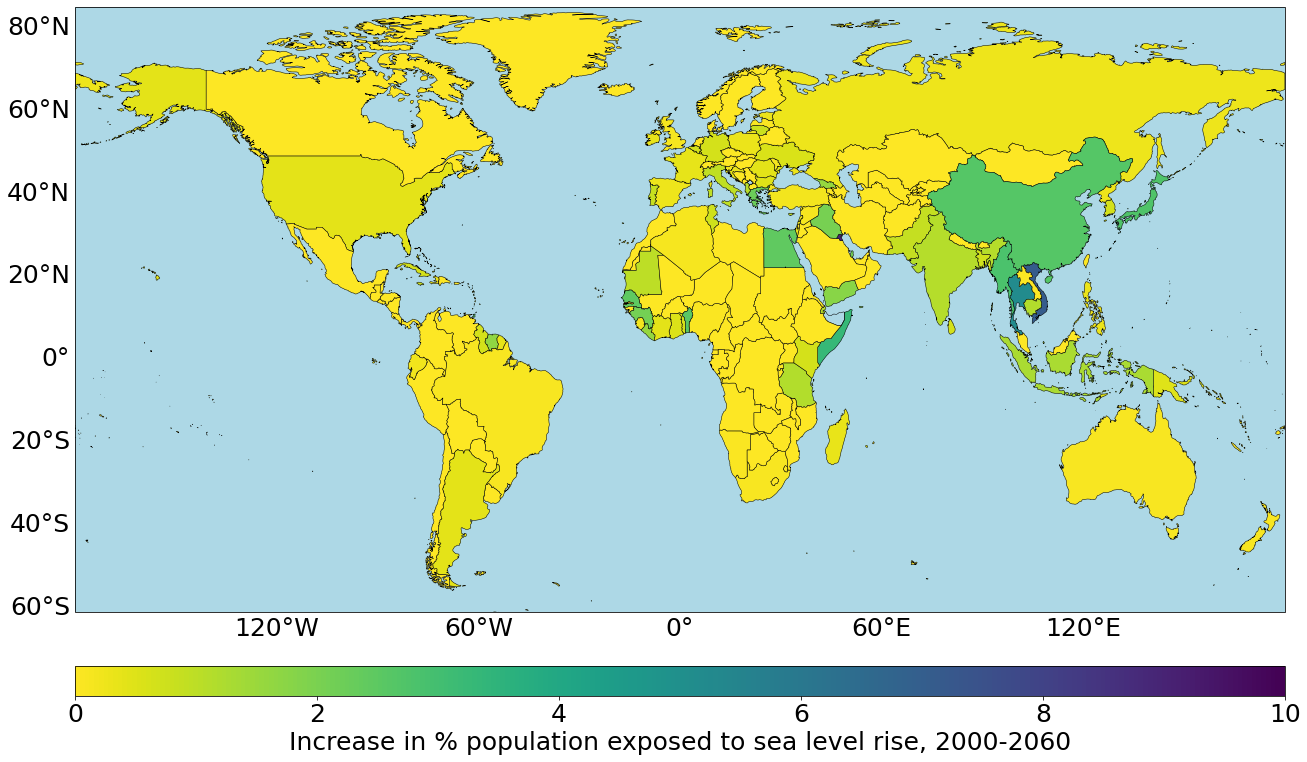

In [9]:
def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.85*b, w, 0.05*h])

borders[vn] = df_iso[vn].where( df_iso[vn] > 0, 0 )
min_v = borders[vn].min()
max_v = borders[vn].max()
rng_v = max_v - min_v
borders[vn] = 10 * ( borders[vn] - min_v ) / rng_v
#borders["nan"] = 0

map = gv.Polygons( borders, vdims = vn ).opts(
    colorbar = True, cmap = "viridis_r", linewidth = 0.5,
    hooks = [hook], colorbar_opts = {"orientation": "horizontal"},
    aspect = 2, fontscale = 2.5, ylim = (-61, 85), bgcolor = "lightblue" )
gv.output( map, size = 600 )

In [10]:
v = "climatology-spei12-annual-mean"
tr = -0.15

i = 2
ds_h = xr.open_dataset(wb_path + wb_files[i])
var_h = ds_h.copy().drop_vars( ["lon_bnds", "lat_bnds"] )
ds_h[v] = ds_h[v].where( ds_h[v] <= tr, 0 )
ds_h[v] = ds_h[v].where( ds_h[v] == 0, 1 )
ds_h["Exposed population"] = pop_h[p] * ds_h[v]

i = 8
ds_f = xr.open_dataset(wb_path + wb_files[i])
var_f = ds_f.copy().drop_vars( ["lon_bnds", "lat_bnds"] )
ds_f[v] = ds_f[v].where( ds_f[v] <= tr, 0 )
ds_f[v] = ds_f[v].where( ds_f[v] == 0, 1 )
ds_f["Exposed population"] = pop_f[p] * ds_f[v]

df_h = ds_h[ [v, "Exposed population"] ].to_dataframe()
df_h["country"] = df_pop_h["country"]
df_h[p] = df_pop_h[p]
df_h = df_h.reset_index().drop(columns = "time").set_index("country")
df_h = df_h[ ~df_h.index.isnull() ]
df_hc = df_h[ [p, "Exposed population"] ].groupby("country").sum()
df_hc["% Exposed population"] = ( df_hc["Exposed population"] / df_hc[p] )

df_f = ds_f[ [v, "Exposed population"] ].to_dataframe()
df_f["country"] = df_pop_f["country"]
df_f[p] = df_pop_f[p]
df_f = df_f.reset_index().drop(columns = "time").set_index("country")
df_f = df_f[ ~df_f.index.isnull() ]
df_fc = df_f[ [p, "Exposed population"] ].groupby("country").sum()
df_fc["% Exposed population"] = ( df_fc["Exposed population"] / df_fc[p] )

vn = ( "Increase in % population exposed to an "
    + "average 12-month SPEI < -0.2, 2005-2050" )
df_fc[vn] = df_fc["% Exposed population"] - df_hc["% Exposed population"]
names = borders[ ["NAME", "ISO_N3_EH"] ].drop_duplicates(
    subset = "ISO_N3_EH" ).reset_index().set_index("ISO_N3_EH")
names.index = names.index.astype(int)
df_fc["NAME"] = names["NAME"]
df_fc[ix] = names[ix]
df_fc = df_fc.reset_index().set_index(ix)
df_iso[vn] = df_fc[vn]

df_fc.sort_values(vn, ascending = False).head(10)

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % population exposed to an average 12-month SPEI < -0.2, 2005-2050",NAME
alpha-3,,,,,,
ISR,376.0,1.283378e+07,1.283378e+07,1.000000,1.000000,Israel
PSE,275.0,8.080783e+06,8.080783e+06,1.000000,1.000000,Palestine
PCN,612.0,6.500599e+01,6.500599e+01,1.000000,1.000000,Pitcairn Is.
DMA,212.0,7.603438e+04,7.603438e+04,1.000000,1.000000,Dominica
LBN,422.0,4.804990e+06,4.804990e+06,1.000000,1.000000,Lebanon
CHL,152.0,2.038885e+07,2.007530e+07,0.984621,0.984174,Chile
SUR,740.0,6.571364e+05,6.372544e+05,0.969745,0.969745,Suriname
JOR,400.0,1.248346e+07,1.209987e+07,0.969272,0.969272,Jordan
DZA,12.0,4.888387e+07,4.714332e+07,0.964394,0.964175,Algeria


In [11]:
df_hc.loc[[242]]

,climatology-popcount-annual-mean,Exposed population,% Exposed population
country,,,
242.0,807657.375,0.0,0.0


In [12]:
df_fc.loc[["FJI"]]

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % population exposed to an average 12-month SPEI < -0.2, 2005-2050",NAME
alpha-3,,,,,,
FJI,242.0,937559.125,0.0,0.0,0.0,Fiji


:Overlay
   .Image.I :Image   [lon,lat]   (Average 12-month SPEI, 2040-2060, climate scenario SSP2-4.5)
   .Path.I  :Path   [Longitude,Latitude]
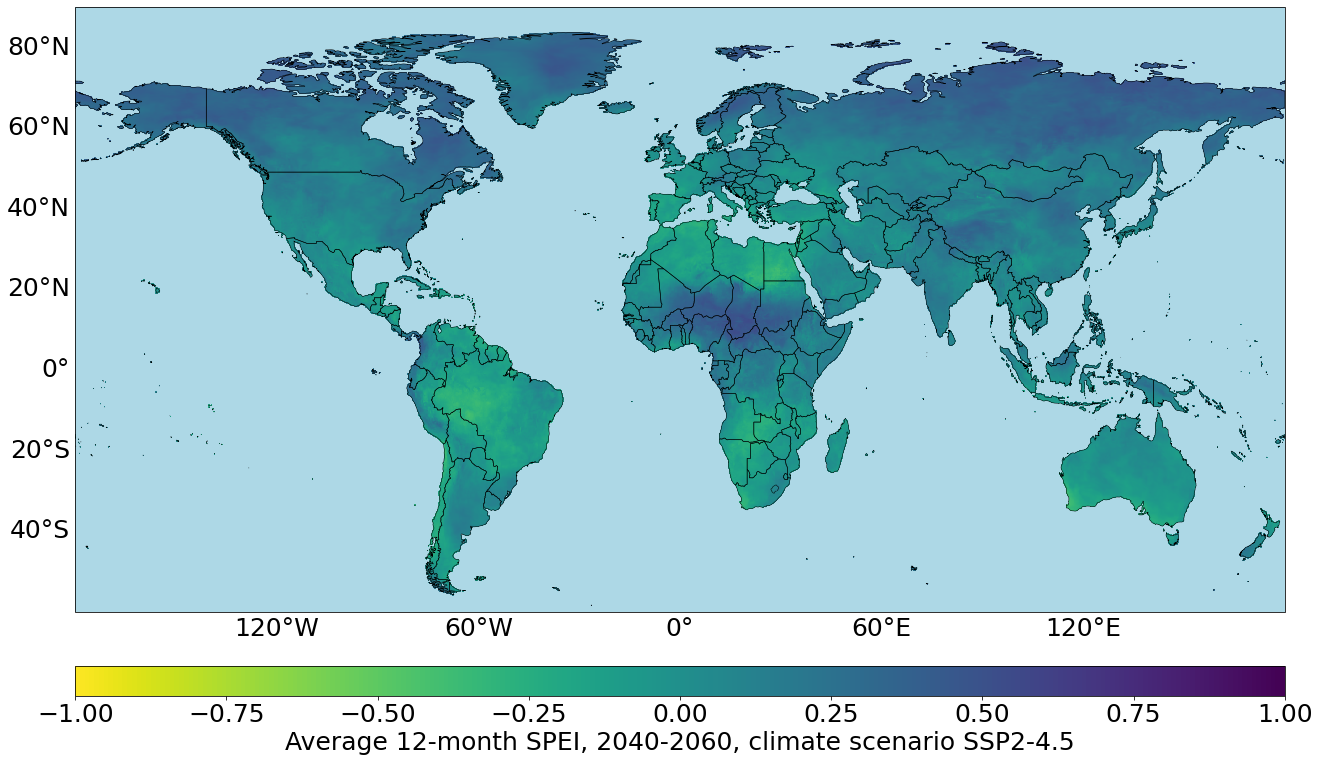

:Polygons   [Longitude,Latitude]   (Increase in % population exposed to an average 12-month SPEI < -0.2, 2005-2050)
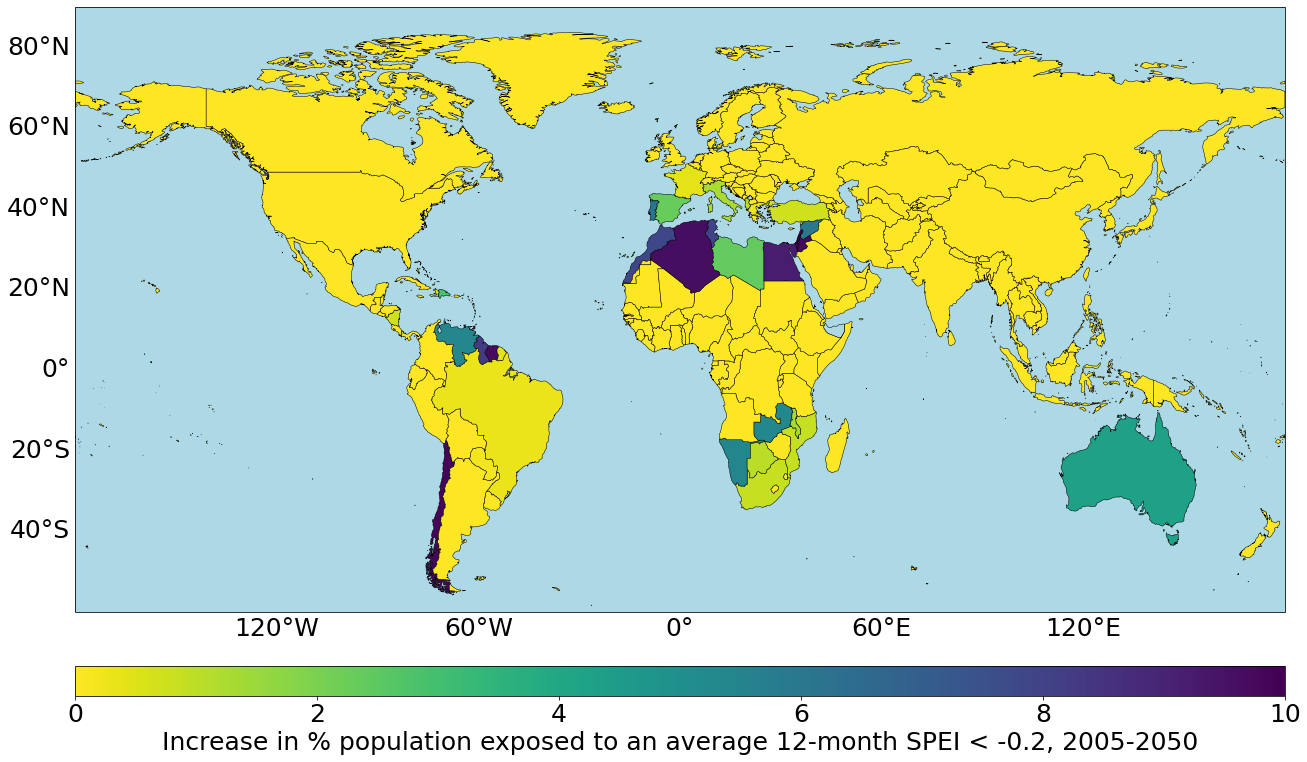

In [13]:
vn_plot = ( "Average 12-month SPEI, "
     + "2040-2060, climate scenario SSP2-4.5" )
ds_map = var_f.rename( {v: vn_plot } )
ds_map[vn_plot] = ds_map[vn_plot].fillna(0)
ds_map = ds_map.rio.write_crs(borders.crs)
ds_map = ds_map.rio.set_spatial_dims("lon", "lat")
ds_map = ds_map.rio.clip( borders.dissolve().geometry,
    drop = False, invert = False, all_touched = True )

min = np.floor( np.nanmin(ds_map[vn_plot].values) )
max = np.ceil( np.nanmax(ds_map[vn_plot].values) )

def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.85*b, w, 0.05*h])

v_map = gv.Image( gv.Dataset( ds_map, ["lon", "lat"],
    vdims = gv.Dimension(vn_plot, range = ( min, max ) ) )
    ).opts( colorbar = True, cmap = "viridis_r",
    hooks = [hook], ylim = (-60, 90), bgcolor = "lightblue",
    colorbar_opts = {"orientation": "horizontal"} )
img = ( v_map * countries ).opts(aspect = 2, fontscale = 2.5)
gv.output( img, size = 600 )

borders[vn] = df_iso[vn].where( df_iso[vn] > 0, 0 )
min_v = borders[vn].min()
max_v = borders[vn].max()
rng_v = max_v - min_v
borders[vn] = 10 * ( borders[vn] - min_v ) / rng_v
#borders["nan"] = 0

map = gv.Polygons( borders, vdims = vn ).opts(
    colorbar = True, cmap = "viridis_r", linewidth = 0.5,
    hooks = [hook], colorbar_opts = {"orientation": "horizontal"},
    aspect = 2, fontscale = 2.5, ylim = (-60, 90), bgcolor = "lightblue" )
gv.output( map, size = 600 )

In [14]:
v = "climatology-hd40-annual-mean"
tr = 8*7

i = 5
ds_h = xr.open_dataset(wb_path + wb_files[i])
ds_h[v] = ds_h[v].astype(float)
var_h = ds_h.copy().drop_vars( ["lon_bnds", "lat_bnds"] )
ds_h[v] = ds_h[v].where( ds_h[v] >= tr, 0 )
ds_h[v] = ds_h[v].where( ds_h[v] == 0, 1 )
ds_h["Exposed population"] = pop_h[p] * ds_h[v]

i = 7
ds_f = xr.open_dataset(wb_path + wb_files[i])
ds_f[v] = ds_f[v].astype(float)
var_f = ds_f.copy().drop_vars( ["lon_bnds", "lat_bnds"] )
ds_f[v] = ds_f[v].where( ds_f[v] >= tr, 0 )
ds_f[v] = ds_f[v].where( ds_f[v] == 0, 1 )
ds_f["Exposed population"] = pop_f[p] * ds_f[v]

df_h = ds_h[ [v, "Exposed population"] ].to_dataframe()
df_h["country"] = df_pop_h["country"]
df_h[p] = df_pop_h[p]
df_h = df_h.reset_index().drop(columns = "time").set_index("country")
df_h = df_h[ ~df_h.index.isnull() ]
df_hc = df_h[ [p, "Exposed population"] ].groupby("country").sum()
df_hc["% Exposed population"] = ( df_hc["Exposed population"] / df_hc[p] )

df_f = ds_f[ [v, "Exposed population"] ].to_dataframe()
df_f["country"] = df_pop_f["country"]
df_f[p] = df_pop_f[p]
df_f = df_f.reset_index().drop(columns = "time").set_index("country")
df_f = df_f[ ~df_f.index.isnull() ]
df_fc = df_f[ [p, "Exposed population"] ].groupby("country").sum()
df_fc["% Exposed population"] = ( df_fc["Exposed population"] / df_fc[p] )

vn = ( "Increase in % Population exposed to "
    + "more than 8 weeks over 40°C, 2005-2050" )
df_fc[vn] = df_fc["% Exposed population"] - df_hc["% Exposed population"]
names = borders[ ["NAME", "ISO_N3_EH"] ].drop_duplicates(
    subset = "ISO_N3_EH" ).reset_index().set_index("ISO_N3_EH")
names.index = names.index.astype(int)
df_fc["NAME"] = names["NAME"]
df_fc[ix] = names[ix]
df_fc = df_fc.reset_index().set_index(ix)
df_iso[vn] = df_fc[vn]

df_fc.sort_values(vn, ascending = False).head(10)

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % Population exposed to more than 8 weeks over 40°C, 2005-2050",NAME
alpha-3,,,,,,
PRY,600.0,9292284.00,9.237189e+06,0.994071,0.896667,Paraguay
MDA,498.0,2334431.50,2.014910e+06,0.863127,0.863127,Moldova
HUN,348.0,9145132.00,6.994250e+06,0.764806,0.764806,Hungary
JOR,400.0,12483461.00,1.243833e+07,0.996385,0.724264,Jordan
BHR,48.0,2829529.50,1.972394e+06,0.697075,0.697075,Bahrain
NAM,516.0,3371045.25,2.431138e+06,0.721182,0.663699,Namibia
KHM,116.0,18062018.00,1.363712e+07,0.755016,0.619164,Cambodia
BWA,72.0,2564531.75,2.393271e+06,0.933219,0.570337,Botswana
GRC,300.0,11204589.00,6.085072e+06,0.543087,0.495957,Greece


In [15]:
df_hc.loc[[242]]

,climatology-popcount-annual-mean,Exposed population,% Exposed population
country,,,
242.0,807657.375,0.0,0.0


In [16]:
df_fc.loc[["FJI"]]

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % Population exposed to more than 8 weeks over 40°C, 2005-2050",NAME
alpha-3,,,,,,
FJI,242.0,937559.125,0.0,0.0,0.0,Fiji


:Overlay
   .Image.I :Image   [lon,lat]   (Number of days exceeding 40°C, 2040-2060, climate scenario SSP2-4.5)
   .Path.I  :Path   [Longitude,Latitude]
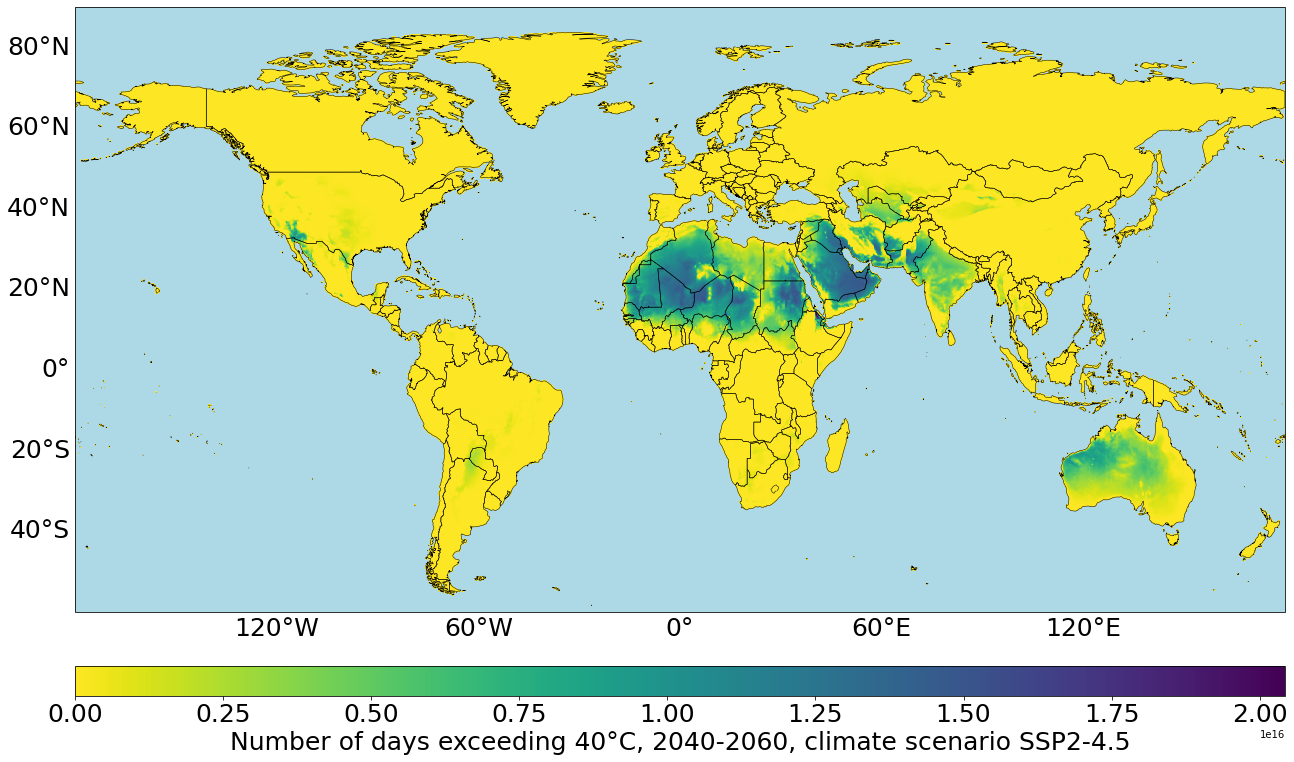

:Polygons   [Longitude,Latitude]   (Increase in % Population exposed to more than 8 weeks over 40°C, 2005-2050)
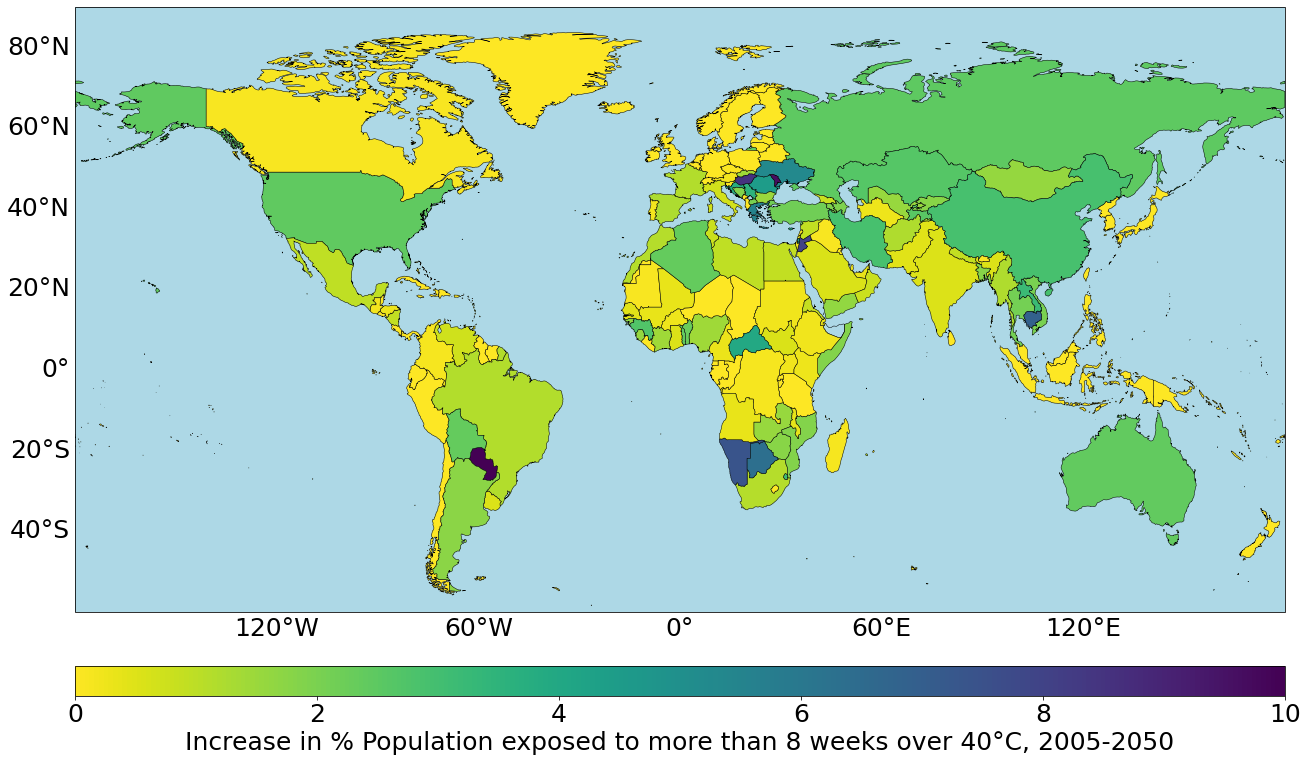

In [17]:
vn_plot = ( "Number of days exceeding 40°C, "
     + "2040-2060, climate scenario SSP2-4.5" )
ds_map = var_f.rename( {v: vn_plot } )
ds_map[vn_plot] = ds_map[vn_plot].fillna(0)
ds_map = ds_map.rio.write_crs(borders.crs)
ds_map = ds_map.rio.set_spatial_dims("lon", "lat")
ds_map = ds_map.rio.clip( borders.dissolve().geometry,
    drop = False, invert = False, all_touched = True )

min = np.floor( np.nanmin(ds_map[vn_plot].values) )
max = np.ceil( np.nanmax(ds_map[vn_plot].values) )

def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.85*b, w, 0.05*h])

v_map = gv.Image( gv.Dataset( ds_map, ["lon", "lat"],
    vdims = gv.Dimension(vn_plot, range = ( min, max ) ) )
    ).opts( colorbar = True, cmap = "viridis_r",
    hooks = [hook], ylim = (-60, 90), bgcolor = "lightblue",
    colorbar_opts = {"orientation": "horizontal"} )
img = ( v_map * countries ).opts(aspect = 2, fontscale = 2.5)
gv.output( img, size = 600 )

borders[vn] = df_iso[vn].where( df_iso[vn] > 0, 0 )
min_v = borders[vn].min()
max_v = borders[vn].max()
rng_v = max_v - min_v
borders[vn] = 10 * ( borders[vn] - min_v ) / rng_v
#borders["nan"] = 0

map = gv.Polygons( borders, vdims = vn ).opts(
    colorbar = True, cmap = "viridis_r", linewidth = 0.5,
    hooks = [hook], colorbar_opts = {"orientation": "horizontal"},
    aspect = 2, fontscale = 2.5, ylim = (-60, 90), bgcolor = "lightblue" )
gv.output( map, size = 600 )

In [18]:
v1 = "climatology-pr-annual-mean"
v2 = "climatology-rx1day-annual-mean"
v = "climatology-percrx1-annual-mean"
tr = 0.05

i = 0
ds_h1 = xr.open_dataset(wb_path + wb_files[i])
i = 9
ds_h2 = xr.open_dataset(wb_path + wb_files[i])
ds_h = ( ds_h2[v2] / ds_h1[v1] ).to_dataset(name = v)
var_h = ds_h.copy()
ds_h[v] = ds_h[v].where( ds_h[v] >= tr, 0 )
ds_h[v] = ds_h[v].where( ds_h[v] == 0, 1 )
ds_h["Exposed population"] = pop_h[p] * ds_h[v]

i = 6
ds_f1 = xr.open_dataset(wb_path + wb_files[i])
i = 3
ds_f2 = xr.open_dataset(wb_path + wb_files[i])
ds_f = ( ds_f2[v2] / ds_f1[v1] ).to_dataset(name = v)
var_f = ds_f.copy()
ds_f[v] = ds_f[v].where( ds_f[v] >= tr, 0 )
ds_f[v] = ds_f[v].where( ds_f[v] == 0, 1 )
ds_f["Exposed population"] = pop_f[p] * ds_f[v]

df_h = ds_h[ [v, "Exposed population"] ].to_dataframe()
df_h["country"] = df_pop_h["country"]
df_h[p] = df_pop_h[p]
df_h = df_h.reset_index().drop(columns = "time").set_index("country")
df_h = df_h[ ~df_h.index.isnull() ]
df_hc = df_h[ [p, "Exposed population"] ].groupby("country").sum()
df_hc["% Exposed population"] = ( df_hc["Exposed population"] / df_hc[p] )

df_f = ds_f[ [v, "Exposed population"] ].to_dataframe()
df_f["country"] = df_pop_f["country"]
df_f[p] = df_pop_f[p]
df_f = df_f.reset_index().drop(columns = "time").set_index("country")
df_f = df_f[ ~df_f.index.isnull() ]
df_fc = df_f[ [p, "Exposed population"] ].groupby("country").sum()
df_fc["% Exposed population"] = ( df_fc["Exposed population"] / df_fc[p] )

vn = ( "Increase in % population exposed to one-day rainfall "
    + "exceeding 5% of annual rainfall, 2005-2050" )
df_fc[vn] = df_fc["% Exposed population"] - df_hc["% Exposed population"]
names = borders[ ["NAME", "ISO_N3_EH"] ].drop_duplicates(
    subset = "ISO_N3_EH" ).reset_index().set_index("ISO_N3_EH")
names.index = names.index.astype(int)
df_fc["NAME"] = names["NAME"]
df_fc[ix] = names[ix]
df_fc = df_fc.reset_index().set_index(ix)
df_iso[vn] = df_fc[vn]

df_fc.sort_values(vn, ascending = False).head(10)

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % population exposed to one-day rainfall exceeding 5% of annual rainfall, 2005-2050",NAME
alpha-3,,,,,,
PCN,612.0,6.500599e+01,6.500599e+01,1.000000,1.000000,Pitcairn Is.
CYP,196.0,1.563562e+06,8.021704e+05,0.513040,0.513040,Cyprus
MAR,504.0,3.815900e+07,3.035745e+07,0.795551,0.236512,Morocco
PSE,275.0,8.080783e+06,4.918146e+06,0.608622,0.204048,Palestine
DZA,12.0,4.888387e+07,3.495999e+07,0.715164,0.192045,Algeria
GRC,300.0,1.120459e+07,6.680048e+06,0.596189,0.143072,Greece
SYR,760.0,3.339885e+07,1.917335e+07,0.574072,0.134808,Syria
TUN,788.0,1.281825e+07,1.217473e+07,0.949797,0.122122,Tunisia
ESP,724.0,5.232599e+07,2.774295e+07,0.530194,0.102012,Spain


In [19]:
df_hc.loc[[242]]

,climatology-popcount-annual-mean,Exposed population,% Exposed population
country,,,
242.0,807657.375,0.0,0.0


In [20]:
df_fc.loc[["FJI"]]

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % population exposed to one-day rainfall exceeding 5% of annual rainfall, 2005-2050",NAME
alpha-3,,,,,,
FJI,242.0,937559.125,0.0,0.0,0.0,Fiji


:Overlay
   .Image.I :Image   [lon,lat]   (1-day maximum rainfall as % of annual rainfall, 2040-2060, climate scenario SSP2-4.5)
   .Path.I  :Path   [Longitude,Latitude]
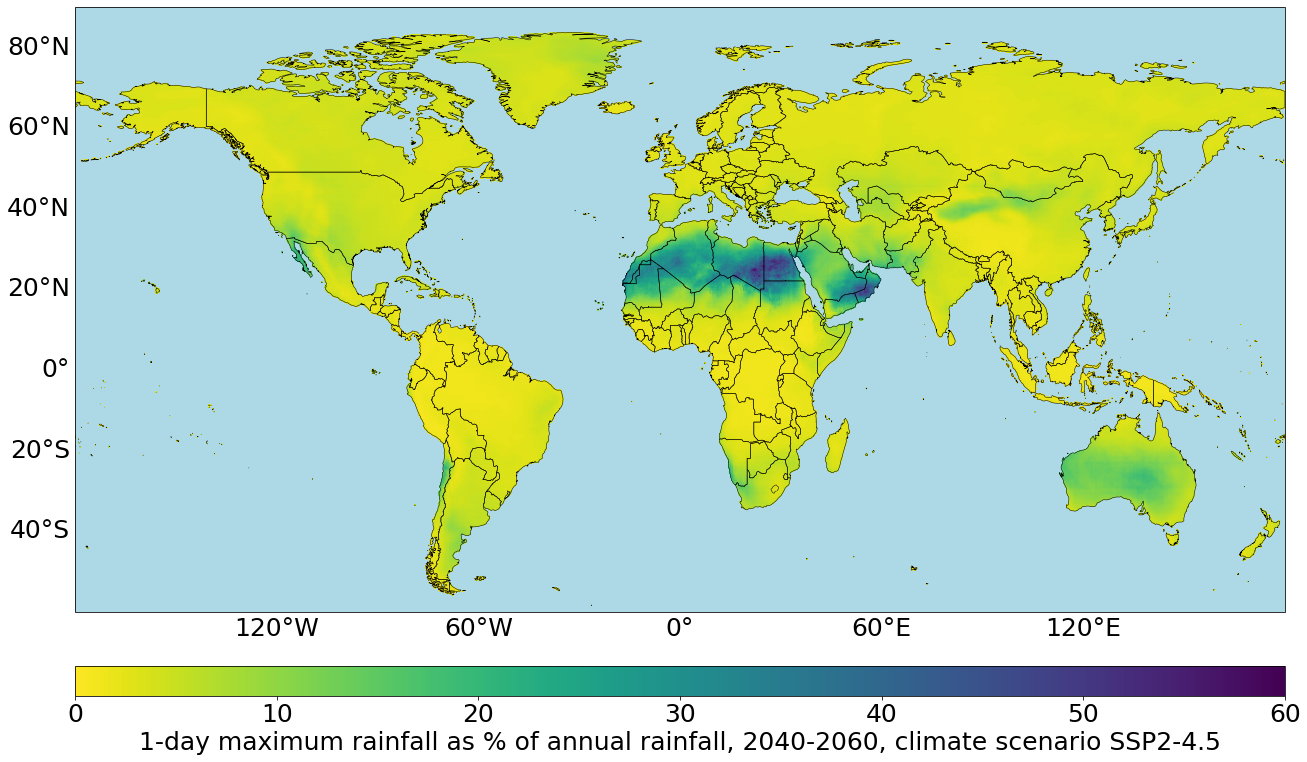

:Polygons   [Longitude,Latitude]   (Increase in % population exposed to one-day rainfall exceeding 5% of annual rainfall, 2005-2050)
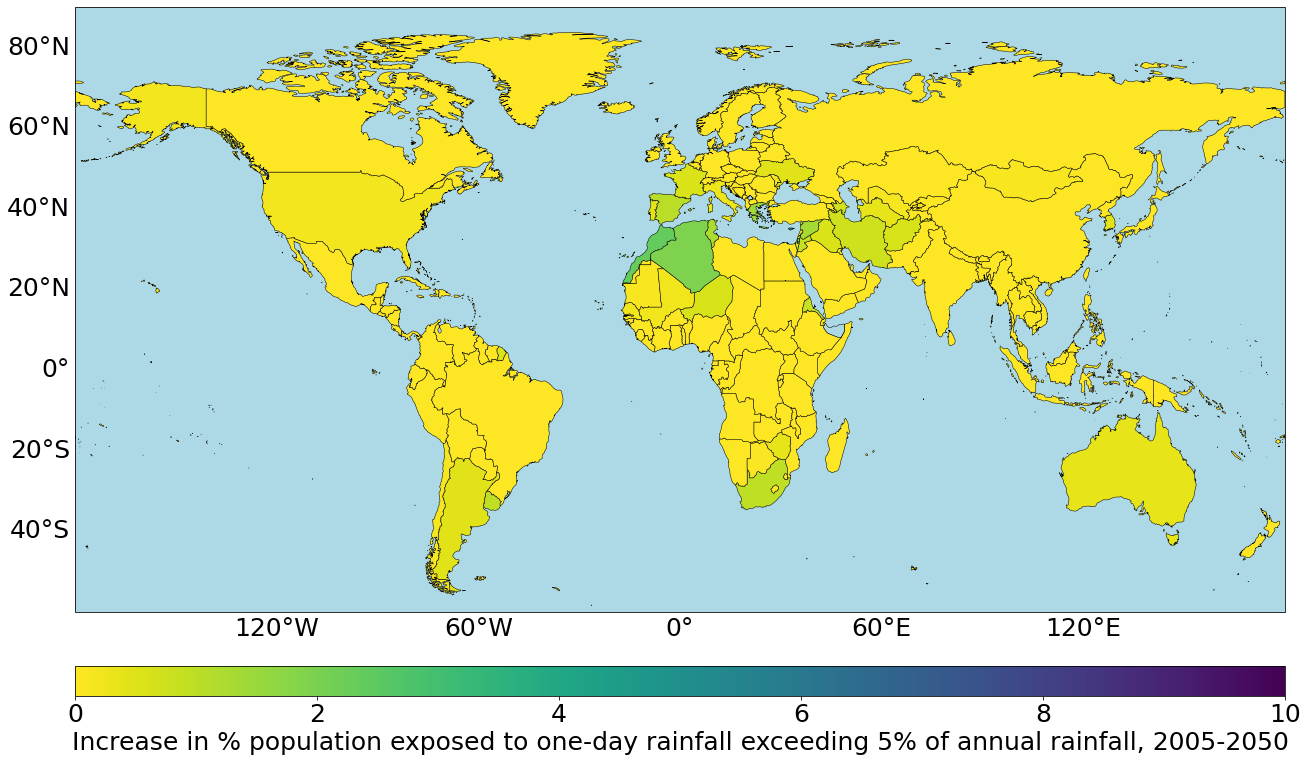

In [21]:
vn_plot = ( "1-day maximum rainfall as % of annual "
     + "rainfall, 2040-2060, climate scenario SSP2-4.5" )
ds_map = var_f.rename( {v: vn_plot } ) * 100
ds_map[vn_plot] = ds_map[vn_plot].fillna(0)
ds_map = ds_map.rio.write_crs(borders.crs)
ds_map = ds_map.rio.set_spatial_dims("lon", "lat")
ds_map = ds_map.rio.clip( borders.dissolve().geometry,
    drop = False, invert = False, all_touched = True )

min = np.floor( np.nanmin(ds_map[vn_plot].values) )
max = np.ceil( np.nanmax(ds_map[vn_plot].values) )

def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.85*b, w, 0.05*h])

v_map = gv.Image( gv.Dataset( ds_map, ["lon", "lat"],
    vdims = gv.Dimension(vn_plot, range = ( min, max ) ) )
    ).opts( colorbar = True, cmap = "viridis_r",
    hooks = [hook], ylim = (-60, 90), bgcolor = "lightblue",
    colorbar_opts = {"orientation": "horizontal"} )
img = ( v_map * countries ).opts(aspect = 2, fontscale = 2.5)
gv.output( img, size = 600 )

borders[vn] = df_iso[vn].where( df_iso[vn] > 0, 0 )
min_v = borders[vn].min()
max_v = borders[vn].max()
rng_v = max_v - min_v
borders[vn] = 10 * ( borders[vn] - min_v ) / rng_v
#borders["nan"] = 0

map = gv.Polygons( borders, vdims = vn ).opts(
    colorbar = True, cmap = "viridis_r", linewidth = 0.5,
    hooks = [hook], colorbar_opts = {"orientation": "horizontal"},
    aspect = 2, fontscale = 2.5, ylim = (-60, 90), bgcolor = "lightblue" )
gv.output( map, size = 600 )

In [22]:
f = "../../Bases_de_datos/GAR2015/VIENTO_MUNDO_TR100_INT1.grd"
v = "100_year_hurricane_wind"
hurr = rio.open_rasterio(f).to_dataset( "band"
    ).rename( {"x": "lon", "y": "lat", 1: v})
regridder = xe.Regridder( hurr, pop_h, method = "bilinear", )#periodic = True )

tr = 209

var_h = regridder( hurr, keep_attrs = True )
var_f = var_h * 1.1

ds_h = var_h.copy()
ds_f = var_f.copy()

ds_h[v] = ds_h[v].where( ds_h[v] >= tr, 0 )
ds_h[v] = ds_h[v].where( ds_h[v] == 0, 1 )
ds_h["Exposed population"] = pop_h[p] * ds_h[v]

ds_f[v] = ds_f[v].where( ds_f[v] >= tr, 0 )
ds_f[v] = ds_f[v].where( ds_f[v] == 0, 1 )
ds_f["Exposed population"] = pop_f[p] * ds_f[v]

df_h = ds_h[ [v, "Exposed population"] ].to_dataframe()
df_h["country"] = df_pop_h["country"].reset_index(level = 0, drop = True)
df_h[p] = df_pop_h[p].reset_index(level = 0, drop = True)
df_h = df_h.reset_index().drop(columns = "time").set_index("country")
df_h = df_h[ ~df_h.index.isnull() ]
df_hc = df_h[ [p, "Exposed population"] ].groupby("country").sum()
df_hc["% Exposed population"] = ( df_hc["Exposed population"] / df_hc[p] )

df_f = ds_f[ [v, "Exposed population"] ].to_dataframe()
df_f["country"] = df_pop_f["country"].reset_index(level = 0, drop = True)
df_f[p] = df_pop_f[p].reset_index(level = 0, drop = True)
df_f = df_f.reset_index().drop(columns = "time").set_index("country")
df_f = df_f[ ~df_f.index.isnull() ]
df_fc = df_f[ [p, "Exposed population"] ].groupby("country").sum()
df_fc["% Exposed population"] = ( df_fc["Exposed population"] / df_fc[p] )

vn = "Increase in % population exposed to category 4 & 5 hurricanes, 2000-2050"
df_fc[vn] = df_fc["% Exposed population"] - df_hc["% Exposed population"]
names = borders[ ["NAME", "ISO_N3_EH"] ].drop_duplicates(
    subset = "ISO_N3_EH" ).reset_index().set_index("ISO_N3_EH")
names.index = names.index.astype(int)
df_fc["NAME"] = names["NAME"]
df_fc[ix] = names[ix]
df_fc = df_fc.reset_index().set_index(ix)
df_iso[vn] = df_fc[vn]

df_fc.sort_values(vn, ascending = False).head(10)

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % population exposed to category 4 & 5 hurricanes, 2000-2050",NAME
alpha-3,,,,,,
NIU,570.0,9.681061e+02,9.681061e+02,1.0,1.0,Niue
VIR,850.0,1.174074e+05,1.174074e+05,1.0,1.0,U.S. Virgin Is.
SXM,534.0,7.091215e+04,7.091215e+04,1.0,1.0,Sint Maarten
TCA,796.0,2.980348e+04,2.980348e+04,1.0,1.0,Turks and Caicos Is.
TON,776.0,8.940720e+04,8.940720e+04,1.0,1.0,Tonga
BMU,60.0,5.805174e+04,5.805174e+04,1.0,1.0,Bermuda
BLM,652.0,1.513041e+03,1.513041e+03,1.0,1.0,St-Barthélemy
PRI,630.0,2.962510e+06,2.962510e+06,1.0,1.0,Puerto Rico
CYM,136.0,6.667695e+04,6.667695e+04,1.0,1.0,Cayman Is.


In [23]:
df_hc.loc[[242]]

,climatology-popcount-annual-mean,Exposed population,% Exposed population
country,,,
242.0,807657.375,0.0,0.0


In [24]:
df_fc.loc[["FJI"]]

,country,climatology-popcount-annual-mean,Exposed population,% Exposed population,"Increase in % population exposed to category 4 & 5 hurricanes, 2000-2050",NAME
alpha-3,,,,,,
FJI,242.0,937559.125,10419.916016,0.011114,0.011114,Fiji


:Overlay
   .Image.I :Image   [lon,lat]   (Hurricane wind, 100-year return period [km/h],2040-2060, climate scenario SSP2-4.5)
   .Path.I  :Path   [Longitude,Latitude]
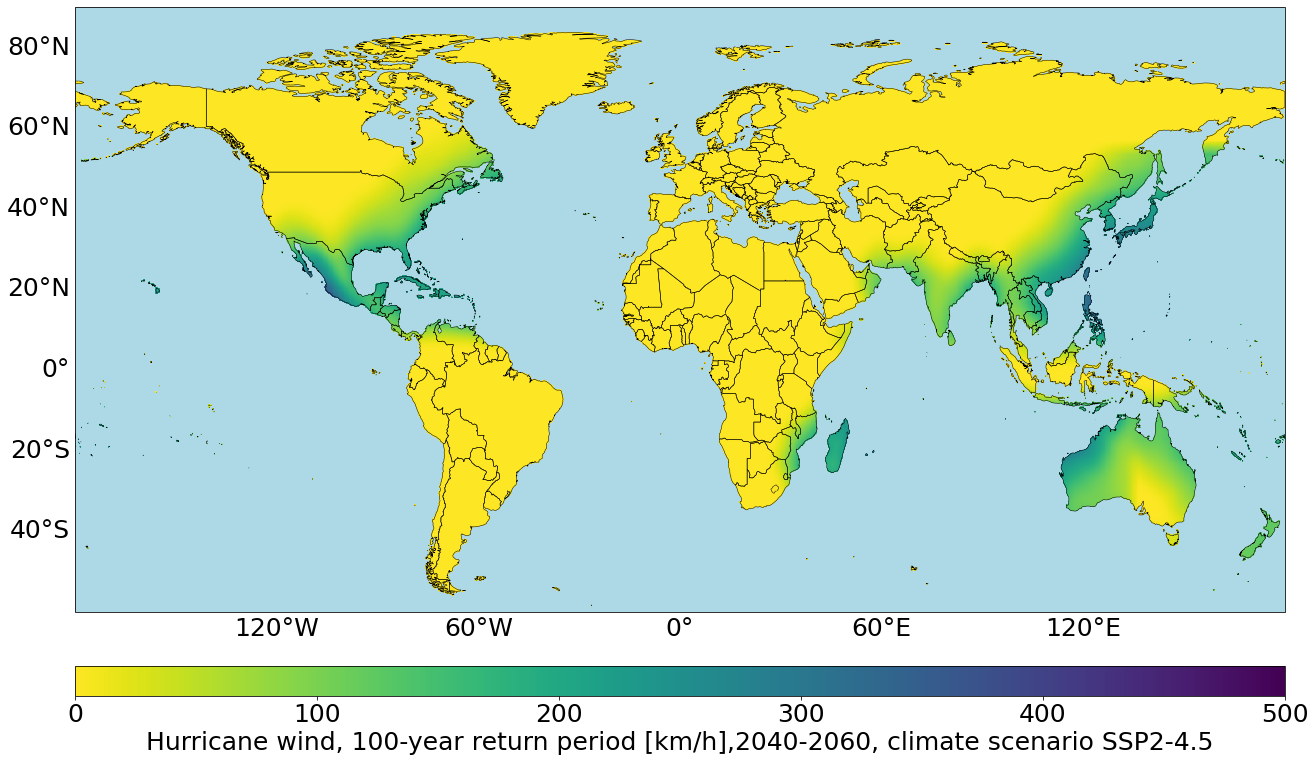

:Polygons   [Longitude,Latitude]   (Increase in % population exposed to category 4 & 5 hurricanes, 2000-2050)
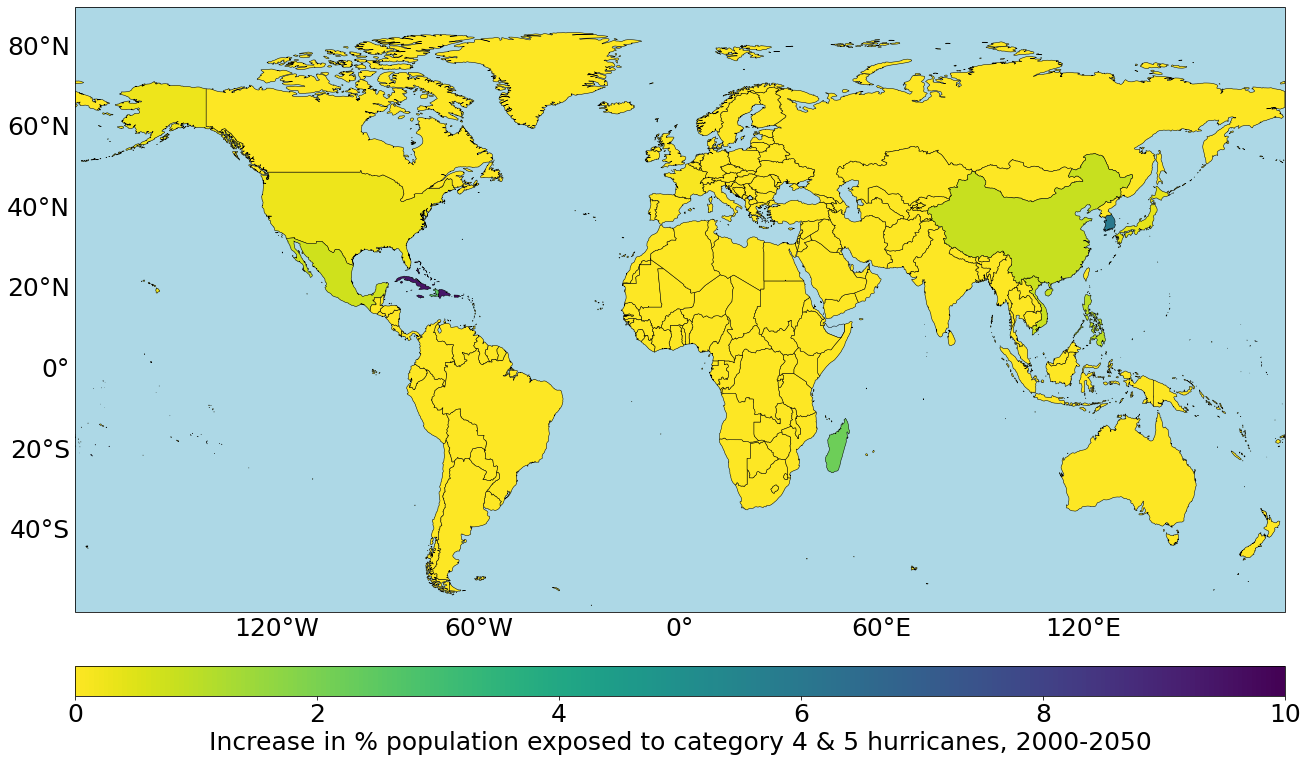

In [25]:
vn_plot = ( "Hurricane wind, 100-year return period [km/h],"
    + "2040-2060, climate scenario SSP2-4.5" )
ds_map = var_f.rename( {"100_year_hurricane_wind": vn_plot } )
ds_map[vn_plot] = ds_map[vn_plot].fillna(0)
ds_map = ds_map.rio.write_crs(borders.crs)
ds_map = ds_map.rio.set_spatial_dims("lon", "lat")
ds_map = ds_map.rio.clip( borders.dissolve().geometry,
    drop = False, invert = False, all_touched = True )

min = np.floor( np.nanmin(ds_map[vn_plot].values) / 50 ) * 50
max = np.ceil( np.nanmax(ds_map[vn_plot].values) / 50 ) * 50

def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.85*b, w, 0.05*h])

v_map = gv.Image( gv.Dataset( ds_map, ["lon", "lat"],
    vdims = gv.Dimension(vn_plot, range = ( min, max ) ) )
    ).opts( colorbar = True, cmap = "viridis_r",
    hooks = [hook], ylim = (-60, 90), bgcolor = "lightblue",
    colorbar_opts = {"orientation": "horizontal"} )
img = ( v_map * countries ).opts(aspect = 2, fontscale = 2.5)
gv.output( img, size = 600 )

borders[vn] = df_iso[vn].where( df_iso[vn] > 0, 0 )
min_v = borders[vn].min()
max_v = borders[vn].max()
rng_v = max_v - min_v
borders[vn] = 10 * ( borders[vn] - min_v ) / rng_v
#borders["nan"] = 0

map = gv.Polygons( borders, vdims = vn ).opts(
    colorbar = True, cmap = "viridis_r", linewidth = 0.5,
    hooks = [hook], colorbar_opts = {"orientation": "horizontal"},
    aspect = 2, fontscale = 2.5, ylim = (-60, 90), bgcolor = "lightblue" )
gv.output( map, size = 600 )

In [26]:
vn = "Climate change risk index"
borders[vn] = borders.iloc[:, -5:-1].sum(axis = 1)

min_v = borders[vn].min()
max_v = borders[vn].max()
rng_v = max_v - min_v
borders[vn] = 10 * ( borders[vn] - min_v ) / rng_v

borders[["NAME", vn]].sort_values( vn, ascending = False ).head(10)

,NAME,Climate change risk index
alpha-3,,
PCN,Pitcairn Is.,10.000000
JOR,Jordan,9.297136
PSE,Palestine,8.284967
DZA,Algeria,7.046896
NAM,Namibia,6.427958
EGY,Egypt,6.279694
DMA,Dominica,5.977427
TTO,Trinidad and Tobago,5.963471
MAR,Morocco,5.679537


:Polygons   [Longitude,Latitude]   (Climate change risk index)
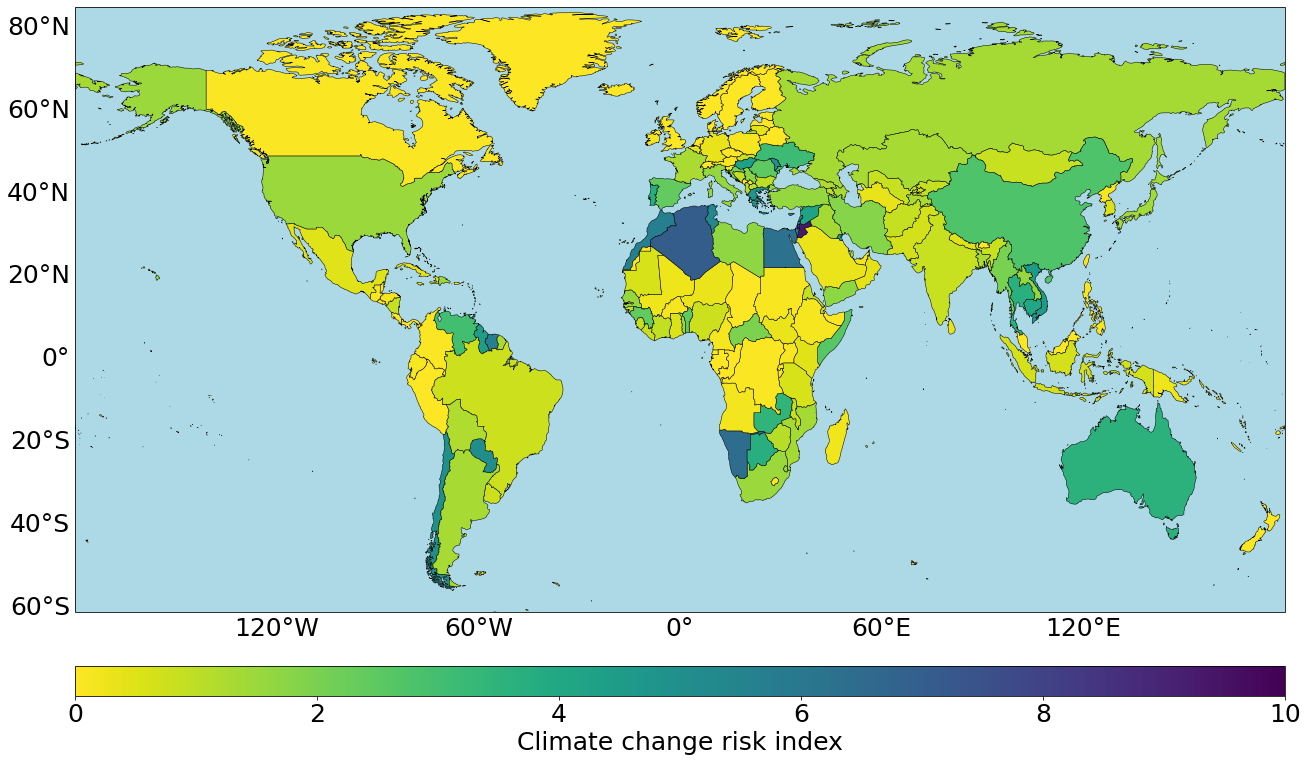

In [27]:
def hook(plot, element):
    cax = plot.handles["cax"]
    ax = plot.handles["axis"]
    bbox = ax.get_position()
    l, b, w, h = bbox.x0, bbox.y0, bbox.width, bbox.height
    cax.set_position([l, 0.85*b, w, 0.05*h])

map = gv.Polygons( borders, vdims = vn ).opts(
    colorbar = True, cmap = "viridis_r", linewidth = 0.5,
    hooks = [hook], colorbar_opts = {"orientation": "horizontal"},
    aspect = 2, fontscale = 2.5, ylim = (-61, 85), bgcolor = "lightblue" )
gv.output( map, size = 600 )

In [28]:
df_iso.loc[["FJI"]]

,name,alpha-2,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,OECD,EU27,BRICS+,BRICS,"Increase in % population exposed to sea level rise, 2000-2060","Increase in % population exposed to an average 12-month SPEI < -0.2, 2005-2050","Increase in % Population exposed to more than 8 weeks over 40°C, 2005-2050","Increase in % population exposed to one-day rainfall exceeding 5% of annual rainfall, 2005-2050","Increase in % population exposed to category 4 & 5 hurricanes, 2000-2050"
alpha-3,,,,,,,,,,,,,,,,,,,
FJI,Fiji,FJ,242,ISO 3166-2:FJ,Oceania,Melanesia,NaN,9.0,54.0,NaN,NaN,NaN,NaN,NaN,-0.876911,0.0,0.0,0.0,0.011114


In [29]:
borders.loc[["FJI"]]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_BD,FCLASS_UA,geometry,Area,"Increase in % population exposed to sea level rise, 2000-2060","Increase in % population exposed to an average 12-month SPEI < -0.2, 2005-2050","Increase in % Population exposed to more than 8 weeks over 40°C, 2005-2050","Increase in % population exposed to one-day rainfall exceeding 5% of annual rainfall, 2005-2050","Increase in % population exposed to category 4 & 5 hurricanes, 2000-2050",Climate change risk index
alpha-3,,,,,,,,,,,,,,,,,,,,,
FJI,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,"MULTIPOLYGON (((179.99922 -16.16855, 179.84824...",1.834634e+10,0.0,0.0,0.0,0.0,0.111139,0.0
